In [4]:
# Listed below are all the libraries you 
# will need for this assignment. Run this
# code chunk everytime you open this file.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import pulp




In [5]:
def ships(x):
    if x > 16000:
        return 4, 1
    elif 14000 < x <= 16000:
        return 4,0
    elif 13000 < x <= 14000:
        return 3,2
    elif 12000 < x <= 13000:
        return 3,1
    elif 10000 < x <= 12000:
        return 3,0
    elif 9000 < x <= 10000:
        return 2,2
    elif 8000 < x <= 9000:
        return 2,1
    elif 6000 < x <= 8000:
        return 2,0
    elif 5000 < x <= 6000:
        return 1,2
    elif 4000 < x <= 5000:
        return 1,1
    elif x < 4000:
        return 1, 0
    

In [6]:
# Fixed Parameters
#Simulation
num_sims = 100              # Number of Simulations
num_years = 20              # Number of Years in each Simulation
num_days = 136              # Number of Days in a Season

#Ship Parameters
NoX_Lg_Hourly = 8303.49     # NoX Produced each hour by a Large Ship
Sm_Ship_Mult = 0.4          # Estimated reduction for consumption and production of small ships, compared to a large ship
NoX_Sm_Hourly = NoX_Lg_Hourly * Sm_Ship_Mult    # NoX Produced each hour by a Small Ship
Dock_Hour_Avg_Lg = 9.67     # Average Hours spent at dock for a Large Ship
Dock_Hour_Sd_Lg = 1.99      # Standard Deviation of Hours spent at a dock for a Large Ship
Dock_Hour_Avg_Sm = 11.31    # Average Hours spent at dock for a Small Ship
Dock_Hour_Sd_Sm = 3.17      # Standard Deviation of Hours spent at a dock for a Small Ship
Elec_Cons_Lg_Avg = 0.93      # Large Ship MW on Average
Elec_Cons_Lg_Sd =  0.07      # Large Ship MW Standard Dev (Max 11) 
Elec_Cons_Sm_Avg = 0.66      # Small Ship MW on Average 
Elec_Cons_Sm_Sd = 0.07     # Small Ship MW Standard Dev (Max 10)

#Maintenance Parameters
Electric_Cost_Kw = 0.112    # Average Cost per Kwh of electricity in Juneau AK 
Diesel_GPH_Lg = 560         # 560 Gallons / Hour for Large Ship (Diesel Consumption per Hour for a Large Ship)
Diesel_GPH_Sm = Sm_Ship_Mult * Diesel_GPH_Lg    # Gallons / Hour for Small Ship (Diesel Consumption per Hour for a Small Ship)
Dock_Ship_Slots = 2         # Number of Available connections per Electrified Dock
CO2_Per_Gal = 0.0116        # Tons of C02 produced per Gallon of Diesel Fuel burned
Gal_Per_Ton = 315           # Number of Gallons of Fuel in one Metric Ton of Diesel
Diesel_Cost = 736           # Estimated Cost of Diesel Fuel per Ton
Maint_Mult = 1.02           # Maintenance Increases by 2% each year

# Initialize Lists for Simulation Outputs

NoX_End_Sim_Decrease = []       # Total NoX Decreased for all years in the Simulation
NoX_Total_Sim = []              # Total NoX Produced for all years in the Simulation
NoX_Total_Sim_Unadj = []        # Total Unadjusted NoX Produced for all years in the Simulation (As if the Projects were not implemented - For Comparison)
Tax_Totals_Sim = []             # Total Tax Collected for all years in the Simulation (All Taxes from All Projects)
Diesel_Reduction_Sim = []       # Total Gallons of Diesel fuel Reduced for all years in the simulation
Total_Cost_Sim = []             # Total Costs associated with projects for all years in the simulation 
CO2_Reduction_Sim = []          # Total Metric Tons of CO2 Decreased for all years in the simulation
CO2_Total_Sim = []              # Total Metric Tons of CO2 produced for all years in the simulation
CO2_Total_Sim_Unadj = []        # Total Unadjusted Metric Tons of CO2 produced for all years in the simulation (As if the Projects were not implemented - For Comparison)


for _ in range(num_sims):

    #Project Parameters
    Perc_Work_Start = 0.5               # Require Tax Buildup of 50% cost to start a project
    Dock1_Est_Length = 2                # Dock 1 Project requires X years for completion
    Dock1_Est_Cost = 13800000           # Estimated Inital Cost of Dock 1 Project
    Dock2_Est_Length = 2                # Dock 2 Project requires X years for completion
    Dock2_Est_Cost = 11100000           # Estimated Inital Cost of Dock 2 Project
    TL_Est_Length = 1                   # Transmission Line Project requires X years for completion
    TL_Est_Cost = (285000*6)            # Estimated Inital Cost of Project (6 miles to Utility Plant)
    Dock1_Maint_Cost = 100000   # Yearly Maintenance Cost of Dock 1 Project
    Dock2_Maint_Cost = 100000   # Yearly Maintenance Cost of Dock 2 Project
    TL_Maint_Cost = 28962 * 6   # Yearly Maintenance Cost of Transmission Line Project    ($28,962/mile @ 6 Miles)

    
    # Initialize Lists For Yearly Calculations
    #NoX
    NoX_Total_Decrease_Year = []        # Total NoX Decreased each year
    NoX_Total_Year = []                 # Total NoX Produced each year
    NoX_Total_Year_Unadj = []           # Total Unadjusted NoX Produced each year (As if the Projects were not implemented - For Comparison)
    #CO2
    CO2_Decrease_Year = []              # Total CO2 Decreased each year
    CO2_Total_Year = []                 # Total CO2 Produced each year
    CO2_Total_Year_Unadj = []           # Total Unadjusted CO2 Produced each year (As if the Projects were not implemented - For Comparison)
    #Tax
    Dock1_Tax_Totals_Year = []           # List for Calcuating Dock 1 Tax
    Dock2_Tax_Totals_Year = []           # List for Calcuating Dock 2 Tax
    TL_Tax_Totals_Year = []              # List for Calcuating 69 KV Transmission Line Tax
    Tax_Totals_Year = []                 # List for Calcuating Total Yearly Tax
    #Electricity
    Electric_Consumption_Year = []      # MW of Electricity consumed each year
    Electric_Cost_Year = []             # Cost of Used Electricity each year
    #Diesel
    Diesel_Reduction_Year = []          # Gallons of Diesel Fuel reduced each year
    #Maintenance            
    Maint_Total_Year = []               # Total cost of Maintenance for all projects each year


    # Initial Yearly Simulation Values
    Dock1_Tax_Per_Pass = 1              # Dock 1 Tax Per Passenger
    Dock1_Complete_Date = False         # Dock 1 Project Complete Date Starts as False
    Dock2_Tax_Per_Pass = 1              # Dock 2 Tax Per Passenger
    Dock2_Complete_Date = False         # Dock 2 Project Complete Date Starts as False
    TL_Tax_Per_Pass = 0.5               # Transmission Line Tax Per Passenger
    TL_Complete_Date = False            # Transmission Line Project Complete Date Starts as False


    for year in range(num_years):

        # Initialize Lists for Daily Calculations
        Large_Count_Day = []            # Number of Large Ships each Day
        Small_Count_Day = []            # Number of Small Ships each Day
        Passenger_Count_Day = []        # Passenger Count Per Day
        NoX_Total_Day = []              # NoX Produced each Day
        NoX_Total_Unadj_Day =[]         # Unadjusted NoX Produced each Day 
        NoX_Decrease_Day = []           # List for Calculating Daily NoX Reduction 
        Dock1_Tax_Totals_Day = []       # Total Tax Generated each Day for Dock 1
        Dock2_Tax_Totals_Day = []       # Total Tax Generated each Day for Dock 2
        TL_Tax_Totals_Day = []          # Total Tax Generated each Day for Transmission Line
        Tax_Totals_Day = []             # Total Tax Generated each Day for all projects 
        Electric_Consumption_Day = []   # MW of Electricity consumed by docks each day
        Electric_Cost_Day = []          # Cost of Electricity consumed each Day
        Diesel_Reduction_Day = []       # Gallons of Diesel fuel reduced each Day
        CO2_Decrease_Day = []           # Metric Tons of CO2 reduced each Day
        CO2_Total_Day = []              # CO2 Produced each Day
        CO2_Total_Unadj_Day =[]         # Unadjusted CO2 Produced each Day 


        # Yearly Dock 1 Tax Calculations & Construction Requirements        
        #Check if Tax is At Least % of Cost To Start Construction 
        if sum(Dock1_Tax_Totals_Year) >= (Perc_Work_Start * Dock1_Est_Cost):  
            Dock1_Construct_Start = True  
        else:
            Dock1_Construct_Start = False 
        
        #Calculate Completion Date of Project 
        if (Dock1_Construct_Start == True)&(Dock1_Complete_Date==False):
            Dock1_Complete_Date = year + Dock1_Est_Length
        elif (Dock1_Construct_Start == True)&(Dock1_Complete_Date!=False):
            Dock1_Complete_Date = Dock1_Complete_Date
        else:
            Dock1_Complete_Date = False

        # Set Project 1 to Completed if Conditions are Met
        if (Dock1_Complete_Date!=False)&(year >= Dock1_Complete_Date):
            Dock1_Completed = True
        else:
            Dock1_Completed = False
        
        # Set Project Paid
        if sum(Dock1_Tax_Totals_Year) >= (Dock1_Est_Cost):  
            Dock1_Paid = True  
        else:
            Dock1_Paid = False

        # Yearly Dock 2 Tax Calculations & Construction Requirements 
        #Check if Tax is At Least % of Cost To Start Construction 
        if sum(Dock2_Tax_Totals_Year) >= (Perc_Work_Start * Dock2_Est_Cost):  
            Dock2_Construct_Start = True  
        else:
            Dock2_Construct_Start = False 
        
        #Calculate Completion Date of Project (in Years)
        if (Dock2_Construct_Start == True)&(Dock2_Complete_Date==False):
            Dock2_Complete_Date = year + Dock2_Est_Length
        elif (Dock2_Construct_Start == True)&(Dock2_Complete_Date!=False):
            Dock2_Complete_Date = Dock2_Complete_Date
        else:
            Dock2_Complete_Date = False

        # Set Project 1 to Completed if Conditions are Met
        if (Dock2_Complete_Date!=False)&(year >= Dock2_Complete_Date):
            Dock2_Completed = True
        else:
            Dock2_Completed = False
        
        # Set Project Paid
        if sum(Dock2_Tax_Totals_Year) >= (Dock2_Est_Cost):  
            Dock2_Paid = True  
        else:
            Dock2_Paid = False

        # Yearly Transmission Line Tax Calculations & Construction Requirements 
        #Check if Tax is At Least % of Cost To Start Construction 
        if sum(TL_Tax_Totals_Year) > (Perc_Work_Start * TL_Est_Cost):  
            TL_Construct_Start = True  
        else:
            TL_Construct_Start = False 
        
        #Calculate Completion Date of Project
        if (TL_Construct_Start == True)&(TL_Complete_Date==False):
            TL_Complete_Date = year + TL_Est_Length
        elif (TL_Construct_Start == True)&(TL_Complete_Date!=False):
            TL_Complete_Date = TL_Complete_Date
        else:
            TL_Complete_Date = False

        # Set Project 1 to Completed if Conditions are Met
        if (TL_Complete_Date!=False)&(year >= TL_Complete_Date):
            TL_Completed = True
        else:
            TL_Completed = False
        
        # Set Project Paid
        if sum(TL_Tax_Totals_Year) >= (TL_Est_Cost):  
            TL_Paid = True  
        else:
            TL_Paid = False
        


        # Initialize Maintenance Values for the Year
        Dock1_Maint_Year = 0
        Dock2_Maint_Year = 0
        TL_Maint_Year = 0
        
        # Check for which projects need maintenance
        if Dock1_Completed == True:
            Dock1_Maint_Year = Dock1_Maint_Cost
        
        if Dock2_Completed == True:
            Dock2_Maint_Year = Dock2_Maint_Cost
        
        if TL_Completed == True:
            TL_Maint_Year = TL_Maint_Cost

                
        # Calculation of Maintenance Costs for the Year
        Maint_Total = Dock1_Maint_Year + Dock2_Maint_Year + TL_Maint_Year
        

        # Initialize any Values for Daily Calculations
        Dock1_Tax_Fund=0        # Dock 1 Daily Tax fund starts at 0 
        Dock2_Tax_Fund=0        # Dock 2 Daily Tax fund starts at 0
        TL_Tax_Fund=0           # Transmission Line Daily Tax fund starts at 0

        for days in range(num_days):

            # Parameters that Reset Each Day
            Cruise_Passengers = np.random.normal(loc=10000, scale=5000/3)   # Cruise Passengers are normally distributed
            Dock1_New_Tax = (Cruise_Passengers*Dock1_Tax_Per_Pass)          # Calculate Dock 1 Daily Tax
            Dock2_New_Tax = (Cruise_Passengers*Dock2_Tax_Per_Pass)          # Calculate Dock 2 Daily Tax
            TL_New_Tax = (Cruise_Passengers*TL_Tax_Per_Pass)                # Calculate Transmission Line Daily Tax
            NoX_Total = 0                                                   # NoX Produced for the Day starts at 0
            NoX_Ship_Decrease = 0                                           # NoX Reduced for the Day starts at 0
            Dock1_Taken = 0                                                 # Dock 1 Connections unavailable for the Day starts at 0
            Dock2_Taken = 0                                                 # Dock 2 Connections unavailable for the Day starts at 0
            Electric_Consumption = 0                                        # MW of Electricity Consumed for the Day starts at 0
            Diesel_Reduction = 0                                            # Gallons of Diesel Reduced for the Day starts at 0
            CO2_Total = 0                                                   # Metric Tons of CO2 Produced for the Day starts at 0
            CO2_Ship_Decrease = 0                                           # Metric Tons of CO2 Reduced for the Day starts at 0
            
            #Tax Calcs
            # Dock 1
            if (Dock1_Paid==False):
                Dock1_Tax_Fund = Dock1_Tax_Fund + Dock1_New_Tax             # Add tax per passenger to Dock 1 Project Tax Fund for that day
            else:
                Dock1_Tax_Fund += 0                                         # If Project is Paid, stop charging tax
            # Dock 2
            if (Dock1_Construct_Start==True):
                if (Dock2_Paid==False):
                    Dock2_Tax_Fund = Dock2_Tax_Fund + Dock2_New_Tax         # Add tax per passenger to Dock 2 Project Tax Fund for that day
                else:
                    Dock2_Tax_Fund += 0                                     # If Project is Paid, stop charging tax
            # Transmission Line
            if (TL_Paid==False):
                TL_Tax_Fund = TL_Tax_Fund + TL_New_Tax                      # Add tax per passenger to Transmission Line Project Tax Fund for that day
            else:
                TL_Tax_Fund += 0                                            # If Project is Paid, stop charging tax
            
            #Call to Ship Function
            Ships_Lg, Ships_Sm = ships(Cruise_Passengers)                   # Return number of Each Ship Type to Utilize for Passenger Count (Values are Optimized via Linear Programming Optimization)

            # Ship Calculations
            #Large Ship Calculations
            for _ in range(1,Ships_Lg+1):                                                   # Calculate NoX Produced By Each Ship Type
                hours = np.random.normal(loc=Dock_Hour_Avg_Lg,scale=Dock_Hour_Sd_Lg)        # Each Ship follows normal distribution of hours at dock
                at_Dock = hours - 3                                                         # Calculate Hours Connected to a Dock
                NoX_Total += NoX_Lg_Hourly * hours                                          # Calculate Total Production of NoX for a Large Ship
                CO2_Total += CO2_Per_Gal * Diesel_GPH_Lg * hours                            # Calculate Total Production of CO2 for a Large Ship
                Elec_Cons_Lg = np.random.normal(loc=Elec_Cons_Lg_Avg,scale=Elec_Cons_Lg_Sd) # Electrical Consumption follows normal distribution
                
                # Check for Available Dock Connections & Calculate associate Costs and Reductions
                if (Dock1_Taken != Dock_Ship_Slots)&(Dock1_Completed == True):                
                    NoX_Ship_Decrease += NoX_Lg_Hourly * at_Dock                            # 3 Hours for connection and disconnection
                    Dock1_Taken += 1                                                        # Denote one Less Available Dock 1 Connection
                    Electric_Consumption += Elec_Cons_Lg * at_Dock                          # Calculate Electrical Consumption for Large Ships
                    Diesel_Reduction += Diesel_GPH_Lg * at_Dock                             # Calculate Diesel Reduction for Large Ships
                    CO2_Ship_Decrease += CO2_Per_Gal * Diesel_GPH_Lg * at_Dock              # Calculate CO2 Reduction for Large Ships
                elif (Dock2_Taken != Dock_Ship_Slots)&(Dock2_Completed == True):
                    NoX_Ship_Decrease += NoX_Lg_Hourly * at_Dock                            # 3 Hours for connection and disconnection for Large Ships
                    Dock2_Taken += 1                                                        # Denote one Less Available Dock 2 Connection
                    Electric_Consumption += Elec_Cons_Lg * at_Dock                          # Calculate Electrical Consumption for Large Ships
                    Diesel_Reduction += Diesel_GPH_Lg * at_Dock                             # Calculate Diesel Reduction  for Large Ships
                    CO2_Ship_Decrease += CO2_Per_Gal * Diesel_GPH_Lg * at_Dock              # Calculate CO2 Reduction for Large Ships
                else:
                    NoX_Ship_Decrease += 0                                                  # If no available Connection, don't adjust current Value
                    Electric_Consumption += 0                                               # If no available Connection, don't adjust current Value
                    Diesel_Reduction += 0                                                   # If no available Connection, don't adjust current Value
                    CO2_Ship_Decrease += 0                                                  # If no available Connection, don't adjust current Value
            #Small Ship Calculations
            for _ in range(Ships_Sm):
                hours = np.random.normal(loc=Dock_Hour_Avg_Sm,scale=Dock_Hour_Sd_Sm)        # Each Ship follows normal distribution of hours at dock
                at_Dock = hours - 3                                                         # Calculate Hours Connected to a Dock
                NoX_Total += NoX_Sm_Hourly * hours                                          # Calculate Total Production of NoX for a Small Ship
                CO2_Total += CO2_Per_Gal * Diesel_GPH_Sm * hours                            # Calculate Total Production of CO2 for a Large Ship
                Elec_Cons_Sm = np.random.normal(loc=Elec_Cons_Sm_Avg,scale=Elec_Cons_Sm_Sd) # Electrical Consumption follows normal distribution

                # Check for Available Dock Connections & Calculate associate Costs and Reductions
                if (Dock1_Taken != Dock_Ship_Slots)&(Dock1_Completed == True):
                    NoX_Ship_Decrease += NoX_Sm_Hourly * at_Dock                            # 3 Hours for connection and disconnection
                    Dock1_Taken += 1                                                        # Denote one Less Available Dock 1 Connection
                    Electric_Consumption += Elec_Cons_Sm * at_Dock                          # Calculate Electrical Consumption for Small Ships
                    Diesel_Reduction += Diesel_GPH_Sm * at_Dock                             # Calculate Diesel Reduction for Small Ships
                    CO2_Ship_Decrease += CO2_Per_Gal * Diesel_GPH_Sm * at_Dock              # Calculate CO2 Reduction for Small Ships
                elif (Dock2_Taken != Dock_Ship_Slots)&(Dock2_Completed == True):
                    NoX_Ship_Decrease += NoX_Sm_Hourly * at_Dock                            # 3 Hours for connection and disconnection
                    Dock2_Taken += 1                                                        # Denote one Less Available Dock 2 Connection
                    Electric_Consumption += Elec_Cons_Sm * at_Dock                          # Calculate Electrical Consumption for Small Ships
                    Diesel_Reduction += Diesel_GPH_Sm * at_Dock                             # Calculate Diesel Reduction for Small Ships
                    CO2_Ship_Decrease += CO2_Per_Gal * Diesel_GPH_Sm * at_Dock              # Calculate CO2 Reduction for Small Ships
                else:
                    NoX_Ship_Decrease += 0                                                  # If no available Connection, don't adjust current Value
                    Electric_Consumption += 0                                               # If no available Connection, don't adjust current Value
                    Diesel_Reduction += 0                                                   # If no available Connection, don't adjust current Value
                    CO2_Ship_Decrease += 0                                                  # If no available Connection, don't adjust current Value
            
            
            # End Day Calculations
            Electric_Cost = Electric_Consumption*1000*Electric_Cost_Kw      # Electrical Consumption to Cost Conversion (MW to KW Conversion * Price)
            NoX_Total_Current = NoX_Total - NoX_Ship_Decrease               # Calculate Total NoX Production for the Day
            CO2_Total_Current = CO2_Total - CO2_Ship_Decrease               # Calculate Total CO2 Production for the Day
            Tax_Total = Dock1_Tax_Fund + Dock2_Tax_Fund + TL_Tax_Fund       # Calculate Total Tax Collected for the Day

            # Append Daily Outputs to Lists
            NoX_Decrease_Day.append(NoX_Ship_Decrease)                      # Append Total NoX Reduction for the Day
            Large_Count_Day.append(Ships_Lg)                                # Append Count of Large Ships for the Day
            Small_Count_Day.append(Ships_Sm)                                # Append Count of Small Ships for the Day
            Passenger_Count_Day.append(Cruise_Passengers)                   # Append Passenger Count for the Day
            NoX_Total_Day.append(NoX_Total_Current)                         # Append Total NoX Production for the Day
            NoX_Total_Unadj_Day.append(NoX_Total)                           # Append Total Unadjusted NoX Production for the Day
            Dock1_Tax_Totals_Day.append(Dock1_Tax_Fund)                     # Append Total Dock 1 Tax Collected for the Day
            Dock2_Tax_Totals_Day.append(Dock2_Tax_Fund)                     # Append Total Dock 2 Tax Collected for the Day
            TL_Tax_Totals_Day.append(TL_Tax_Fund)                           # Append Total Transmission Line Tax Collected for the Day
            Tax_Totals_Day.append(Tax_Total)                                # Append Total Taxes Collected for the Day
            Electric_Consumption_Day.append(Electric_Consumption)           # Append Total MW of Electrical Consumption for the Day
            Electric_Cost_Day.append(Electric_Cost)                         # Append Total Cost of Electricity Consumed for the Day
            Diesel_Reduction_Day.append(Diesel_Reduction)                   # Append Total Gallons of Diesel Reduced for the Day
            CO2_Decrease_Day.append(CO2_Ship_Decrease)                      # Append Total Metric Tons of CO2 Reduced for the Day
            CO2_Total_Day.append(CO2_Total_Current)                         # Append Total CO2 Production for the Day
            CO2_Total_Unadj_Day.append(CO2_Total)                           # Append Total Unadjusted CO2 Production for the Day
        
        df_Day = pd.DataFrame({                                             # Dataframe containing Daily Outputs
            'Day': np.arange(1, num_days + 1),
            'Large': Large_Count_Day,
            'Small' : Small_Count_Day,
            'Passengers' : Passenger_Count_Day,
            'NoX Decrease' : NoX_Decrease_Day,
            'NoX Total' : NoX_Total_Day,
            'NoX Total Unadj': NoX_Total_Unadj_Day,
            'CO2 Decrease' : CO2_Decrease_Day,
            'CO2 Total' : CO2_Total_Day,
            'CO2 Total Unadj': CO2_Total_Unadj_Day,
            'Dock 1 Tax' : Dock1_Tax_Totals_Day,
            'Dock 2 Tax' : Dock2_Tax_Totals_Day,
            'Trans. Line Tax' : TL_Tax_Totals_Day,
            'Elec Consumption': Electric_Consumption_Day,
            'Elec Consumption Cost' : Electric_Cost_Day,         
            'Diesel Reduction' : Diesel_Reduction_Day,
            'Diesel Reduction Cost' : np.array(Diesel_Reduction_Day)/Gal_Per_Ton*Diesel_Cost,   # Gal to Ton conversion * price per ton
            'Total Tax' : Tax_Totals_Day,
        })

        Dock1_Maint_Cost = Dock1_Maint_Cost*Maint_Mult      # Yearly Maintenance Increase of Dock 1 Project
        Dock2_Maint_Cost = Dock2_Maint_Cost*Maint_Mult      # Yearly Maintenance Increase of Dock 2 Project
        TL_Maint_Cost = TL_Maint_Cost*Maint_Mult            # Yearly Maintenance Increase of Transmission Line Project    ($28,962/mile @ 6 Miles)


        # Append Yearly Outputs to Lists
        Electric_Consumption_Year.append(sum(Electric_Consumption_Day))                 # Append Total MW of Electrical Consumption for the Year
        Electric_Cost_Year.append(sum(Electric_Cost_Day))                               # Append Total Cost of Electricity Consumed for the Year
        Dock1_Tax_Totals_Year.append(Dock1_Tax_Totals_Day[num_days-1])                  # Append Total Dock 1 Tax Collected for the Year
        Dock2_Tax_Totals_Year.append(Dock2_Tax_Totals_Day[num_days-1])                  # Append Total Dock 2 Tax Collected for the Year
        TL_Tax_Totals_Year.append(TL_Tax_Totals_Day[num_days-1])                        # Append Total Transmission Line Tax Collected for the Year
        NoX_Total_Decrease_Year.append(sum(NoX_Decrease_Day))                           # Append Total NoX Reduced for the Year
        NoX_Total_Year.append(sum(NoX_Total_Day))                                       # Append Total NoX Production for the Year
        NoX_Total_Year_Unadj.append(sum(NoX_Total_Unadj_Day))                           # Append Total Unadjusted NoX Production for the Year
        CO2_Decrease_Year.append(sum(CO2_Decrease_Day))                                 # Append Total CO2 Reduction for the Year
        CO2_Total_Year.append(sum(CO2_Total_Day))                                       # Append Total CO2 Production for the Year
        CO2_Total_Year_Unadj.append(sum(CO2_Total_Unadj_Day))                           # Append Total Unadjusted CO2 Production for the Year
        Maint_Total_Year.append(Maint_Total)                                            # Append Total Maintenance Costs of All projects for the Year   
        Diesel_Reduction_Year.append(sum(Diesel_Reduction_Day))                         # Append Total Gallons of Diesel Reduced for the Year
        Tax_Totals_Year.append(Tax_Totals_Day[num_days-1])                              # Append Total Tax Colleted for the Year
        
        

    df_Year = pd.DataFrame({                                                # Dataframe containing Yearly Outputs
        'Year' : np.arange(1,num_years+1),
        'NoX Decrease' : NoX_Total_Decrease_Year,
        'NoX Total' : NoX_Total_Year,
        'NoX Total Unadj' : NoX_Total_Year_Unadj,
        'CO2 Decrease' : CO2_Decrease_Year,
        'CO2 Total' : CO2_Total_Year,
        'CO2 Total Unadj': CO2_Total_Year_Unadj,
        'Dock 1 Tax' : Dock1_Tax_Totals_Year,
        'Dock 2 Tax' : Dock2_Tax_Totals_Year,
        'Trans. Line Tax' : TL_Tax_Totals_Year,
        'Elec Consumption' : Electric_Consumption_Year,
        'Elec Consumption Cost' : Electric_Cost_Year,   
        'Diesel Reduction' : Diesel_Reduction_Year,
        'Diesel Reduction Cost' : np.array(Diesel_Reduction_Year)/Gal_Per_Ton*Diesel_Cost,       # Gal to Ton conversion * price per ton
        'Maint Total': Maint_Total_Year,
        'Tax Total' : Tax_Totals_Year,
    })

    # Append Simulation Outputs to Lists
    NoX_End_Sim_Decrease.append(sum(NoX_Total_Decrease_Year))                   # Append total NoX Decrease for the Simulation
    CO2_Reduction_Sim.append(sum(CO2_Decrease_Year))                            # Append total CO2 Decrease for the Simulation
    Tax_Totals_Sim.append(sum(Tax_Totals_Year))                                 # Append total Tax Collected for the Simulation
    Diesel_Reduction_Sim.append(sum(Diesel_Reduction_Year))                     # Append Total Gallons of Diesel Reduced for the Simulation
    Total_Cost_Sim.append(sum(Maint_Total_Year)+sum(Electric_Cost_Year))        # Append Total Costs of Projects for the Simulation
    

df_Sim = pd.DataFrame({                                                     # Dataframe for Simulation Outputs
    'Sim' : np.arange(1,num_sims+1),
    'NoX Decrease' : NoX_End_Sim_Decrease,
    'CO2 Decrease' : CO2_Reduction_Sim,
    'Diesel Reduction' : Diesel_Reduction_Sim,
    'Diesel Reduction Cost' : np.array(Diesel_Reduction_Sim)/Gal_Per_Ton*Diesel_Cost, 
    'Tax Total' : Tax_Totals_Sim,
    'Total Costs' : Total_Cost_Sim,
})
df_Sim.describe()


,Sim,NoX Decrease,CO2 Decrease,Diesel Reduction,Diesel Reduction Cost,Tax Total,Total Costs
count,100.000000,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,50.500000,2.264426e+08,177150.968495,1.527164e+07,3.568230e+07,2.923440e+07,9.256700e+06
std,29.011492,2.767689e+06,2165.223135,1.866572e+05,4.361260e+05,1.151431e+05,6.349763e+04
min,1.000000,2.228869e+08,174369.217283,1.503183e+07,3.512199e+07,2.892727e+07,9.207622e+06
25%,25.750000,2.253938e+08,176330.472943,1.520090e+07,3.551703e+07,2.917222e+07,9.238738e+06
50%,50.500000,2.261434e+08,176916.855582,1.525145e+07,3.563514e+07,2.922363e+07,9.249400e+06
75%,75.250000,2.270759e+08,177646.409322,1.531435e+07,3.578209e+07,2.928960e+07,9.263454e+06
max,100.000000,2.501908e+08,195729.680711,1.687325e+07,3.942448e+07,2.962655e+07,9.822138e+06


In [7]:
df_Year.describe()

,Year,NoX Decrease,NoX Total,NoX Total Unadj,CO2 Decrease,CO2 Total,CO2 Total Unadj,Dock 1 Tax,Dock 2 Tax,Trans. Line Tax,Elec Consumption,Elec Consumption Cost,Diesel Reduction,Diesel Reduction Cost,Maint Total,Tax Total
count,20.00000,2.000000e+01,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,20.000000,2.000000e+01
mean,10.50000,1.130457e+07,1.992298e+07,3.122755e+07,8843.813335,15586.176724,24429.990059,7.495798e+05,6.152000e+05,100787.331231,1346.783034,150839.699779,7.623977e+05,1.781348e+06,311176.730920,1.465567e+06
std,5.91608,9.798375e+06,9.866519e+06,4.996206e+05,7665.481011,7718.791322,390.863994,6.957438e+05,6.978898e+05,246169.780274,1188.154541,133073.308613,6.608173e+05,1.544005e+06,185558.972299,1.024490e+06
min,1.00000,0.000000e+00,9.348312e+06,3.024726e+07,0.000000,7313.387046,23663.088539,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,5.75000,0.000000e+00,9.610302e+06,3.081751e+07,0.000000,7518.347243,24109.201649,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,190917.847327,9.991083e+05
50%,10.50000,1.501940e+07,1.648368e+07,3.127314e+07,11749.998627,12895.537022,24465.651960,1.338203e+06,0.000000e+00,0.000000,1680.989253,188270.796343,1.012931e+06,2.366721e+06,330454.711524,1.369129e+06
75%,15.25000,2.127801e+07,3.099906e+07,3.159411e+07,16646.247683,24251.239018,24716.758967,1.366362e+06,1.367311e+06,0.000000,2627.432335,294272.421554,1.435021e+06,3.352939e+06,495650.137309,2.204223e+06
max,20.00000,2.204513e+07,3.212516e+07,3.212516e+07,17246.380898,25132.209464,25132.209464,1.387474e+06,1.387474e+06,677543.759099,2711.771849,303718.447041,1.486757e+06,3.473819e+06,544515.225578,2.774948e+06


In [8]:
df_Day.describe()

,Day,Large,Small,Passengers,NoX Decrease,NoX Total,NoX Total Unadj,CO2 Decrease,CO2 Total,CO2 Total Unadj,Dock 1 Tax,Dock 2 Tax,Trans. Line Tax,Elec Consumption,Elec Consumption Cost,Diesel Reduction,Diesel Reduction Cost,Total Tax
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.0,136.0,136.0,136.000000,136.000000,136.000000,136.000000,136.0
mean,68.500000,2.507353,0.735294,10007.377963,159004.641876,70590.600543,229595.242419,124.392774,55.224555,179.617329,0.0,0.0,0.0,19.534814,2187.899180,10723.514986,25055.577872,0.0
std,39.403892,0.530497,0.845338,1748.043268,36561.595885,13705.415822,46218.990969,28.602928,10.722044,36.158117,0.0,0.0,0.0,4.843160,542.433867,2465.769658,5761.290375,0.0
min,1.000000,2.000000,0.000000,6397.523280,65944.594421,49820.940000,115765.534421,51.589884,38.976000,90.565884,0.0,0.0,0.0,8.013794,897.544977,4447.403788,10391.394246,0.0
25%,34.750000,2.000000,0.000000,8809.688557,135371.789586,59785.128000,202992.629175,105.904282,46.771200,158.805529,0.0,0.0,0.0,16.568713,1855.695831,9129.679468,21331.568535,0.0
50%,68.500000,2.000000,0.000000,9982.194099,157506.065775,69749.316000,229210.749020,123.220405,54.566400,179.316531,0.0,0.0,0.0,19.360988,2168.430626,10622.448734,24819.435771,0.0
75%,102.250000,3.000000,2.000000,11184.026184,178057.123667,74731.410000,255993.825741,139.297943,58.464000,200.269512,0.0,0.0,0.0,22.506106,2520.683910,12008.443348,28057.823187,0.0
max,136.000000,4.000000,2.000000,14405.140211,267504.769050,126186.864297,367146.649050,209.274772,98.718716,287.226772,0.0,0.0,0.0,31.956366,3579.112937,18040.928654,42152.772982,0.0


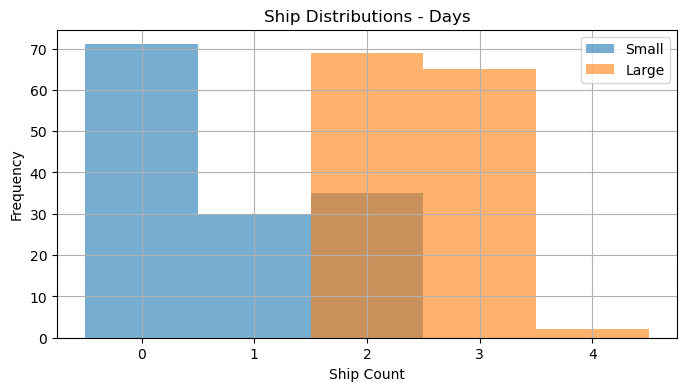

In [9]:
x = df_Day['Day']
a = df_Day['Large']
b = df_Day['Small']
d = a+b
c = df_Day['Passengers']

plt.figure(figsize=(8,4))
plt.hist(b, range=(0,5), bins=5, alpha = 0.6, label='Small',align='left')
plt.hist(a, range=(0,5), bins=5, alpha = 0.6, label='Large',align='left')
#plt.hist(d, range=(0,5), bins=5, alpha = 0.6, label='Total Ships',align='left')
plt.legend()
plt.title('Ship Distributions - Days')
plt.xlabel('Ship Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
#plt.plot(x, a, label = 'Large')
#plt.plot(x, b, label = 'Small')
#plt.plot(x, c, label = 'Count')
#plt.xlabel('Simulation')
#plt.ylabel('Ships')
#plt.title('Count to Ships')
#plt.legend()

plt.show()

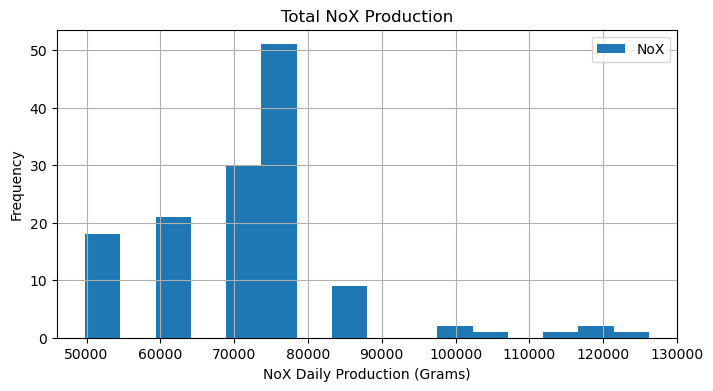

In [10]:
plt.figure(figsize=(8, 4))
a= df_Day['NoX Total']
plt.hist(a, range=(min(a),max(a)), bins=16, label='NoX')
plt.legend()

plt.ylabel('Frequency')
plt.xlabel('NoX Daily Production (Grams)')
plt.title('Total NoX Production')
plt.grid(True)
plt.show()

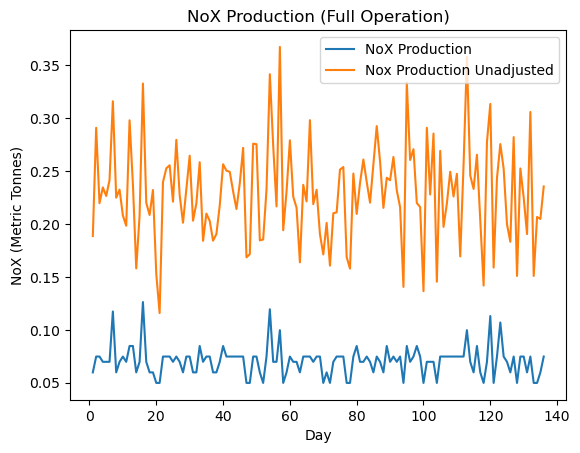

In [11]:
x = df_Day['Day']
a = df_Day['NoX Total']/1000000
b = df_Day['NoX Total Unadj']/1000000


plt.plot(x, a, label = 'NoX Production')
plt.plot(x, b, label = 'Nox Production Unadjusted')
plt.xlabel('Day')
plt.ylabel('NoX (Metric Tonnes)')
plt.title('NoX Production (Full Operation)')
plt.legend()





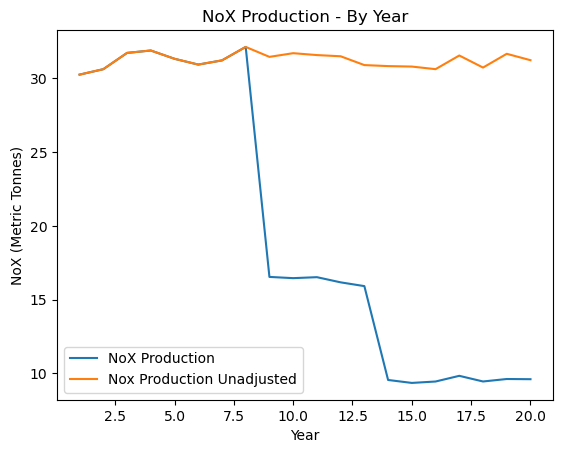

In [12]:
unit = 1000000
x = df_Year['Year']
a = df_Year['NoX Total']/unit
b = df_Year['NoX Total Unadj']/unit


plt.plot(x, a, label = 'NoX Production')
plt.plot(x, b, label = 'Nox Production Unadjusted')
plt.xlabel('Year')
plt.ylabel('NoX (Metric Tonnes)')
plt.title('NoX Production - By Year')
plt.legend()





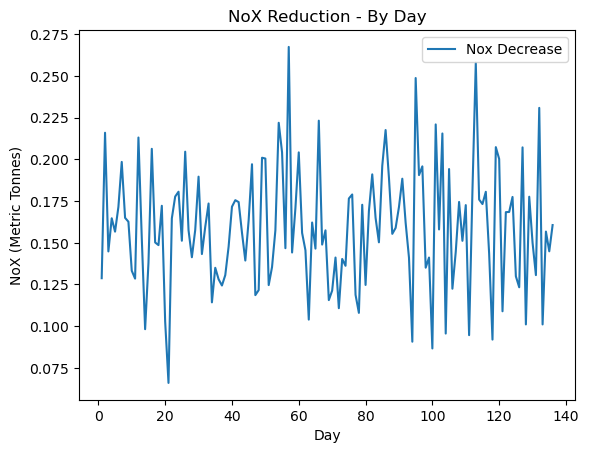

In [13]:
unit = 1000000       # Grams to Ton Conversion
x = df_Day['Day']
a = df_Day['NoX Decrease']/unit


plt.plot(x, a, label = 'Nox Decrease')
plt.xlabel('Day')
plt.ylabel('NoX (Metric Tonnes)')
plt.title('NoX Reduction - By Day')
plt.legend()


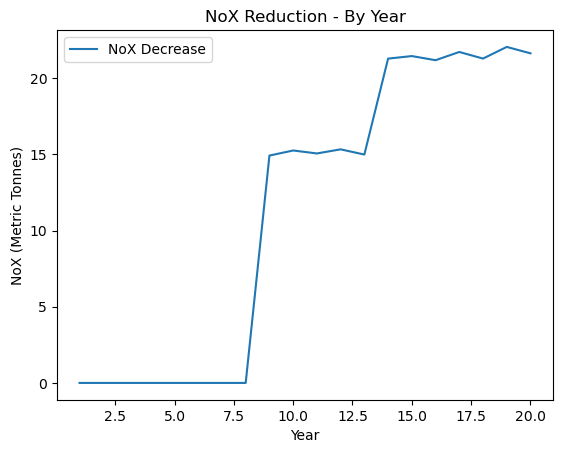

In [14]:
unit = 1000000
x = df_Year['Year']
a = df_Year['NoX Total']/unit
b = df_Year['NoX Total Unadj']/unit
c= b - a

plt.plot(x, c, label = 'NoX Decrease')
plt.xlabel('Year')
plt.ylabel('NoX (Metric Tonnes)')
plt.title('NoX Reduction - By Year')
plt.legend()



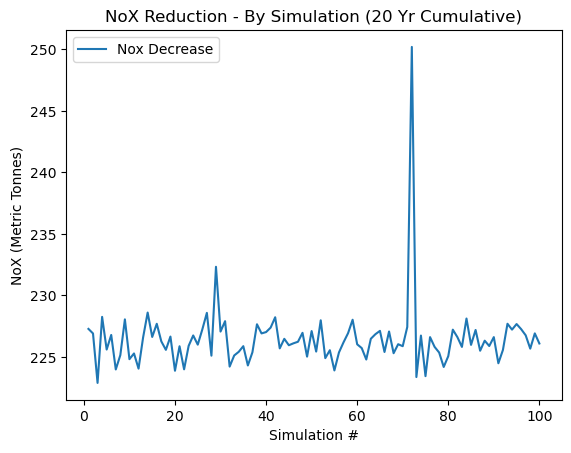

In [15]:
unit = 1000000
x = df_Sim['Sim']
a = df_Sim['NoX Decrease']/unit


plt.plot(x, a, label = 'Nox Decrease')
plt.xlabel('Simulation #')
plt.ylabel('NoX (Metric Tonnes)')
plt.title('NoX Reduction - By Simulation (20 Yr Cumulative)')
plt.legend()

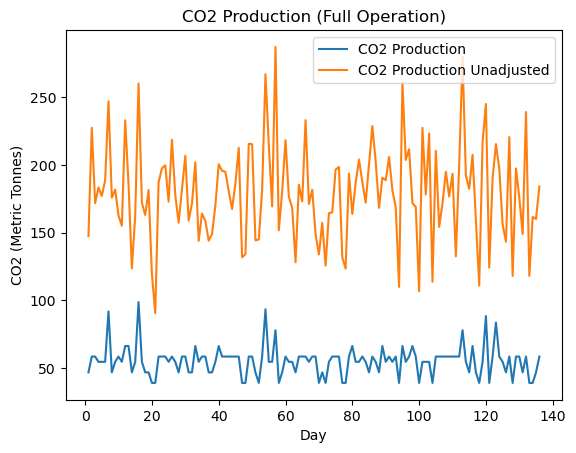

In [16]:
x = df_Day['Day']
a = df_Day['CO2 Total']
b = df_Day['CO2 Total Unadj']


plt.plot(x, a, label = 'CO2 Production')
plt.plot(x, b, label = 'CO2 Production Unadjusted')
plt.xlabel('Day')
plt.ylabel('CO2 (Metric Tonnes)')
plt.title('CO2 Production (Full Operation)')
plt.legend()





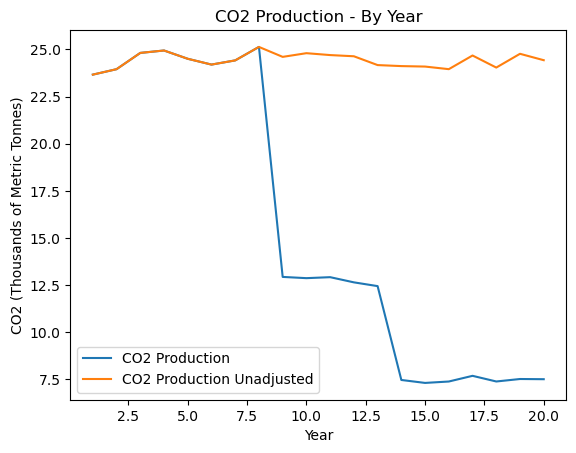

In [17]:
unit = 1000
x = df_Year['Year']
a = df_Year['CO2 Total']/unit
b = df_Year['CO2 Total Unadj']/unit


plt.plot(x, a, label = 'CO2 Production')
plt.plot(x, b, label = 'CO2 Production Unadjusted')
plt.xlabel('Year')
plt.ylabel('CO2 (Thousands of Metric Tonnes)')
plt.title('CO2 Production - By Year')
plt.legend()





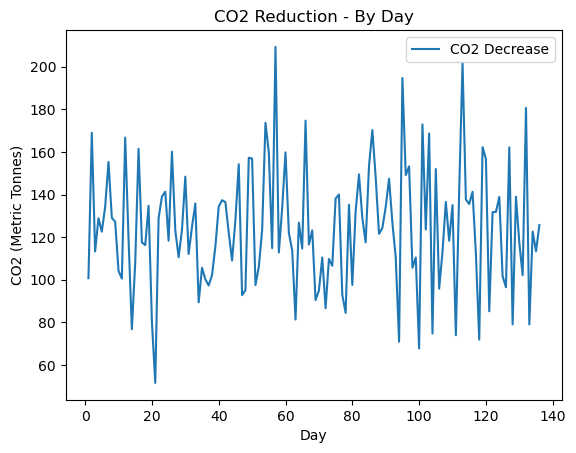

In [18]:

x = df_Day['Day']
a = df_Day['CO2 Decrease']


plt.plot(x, a, label = 'CO2 Decrease')
plt.xlabel('Day')
plt.ylabel('CO2 (Metric Tonnes)')
plt.title('CO2 Reduction - By Day')
plt.legend()


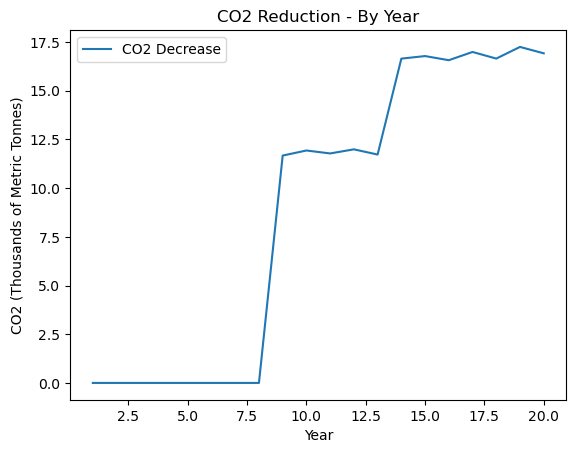

In [19]:
unit = 1000
x = df_Year['Year']
a = df_Year['CO2 Decrease']/unit


plt.plot(x, a, label = 'CO2 Decrease')
plt.xlabel('Year')
plt.ylabel('CO2 (Thousands of Metric Tonnes)')
plt.title('CO2 Reduction - By Year')
plt.legend()

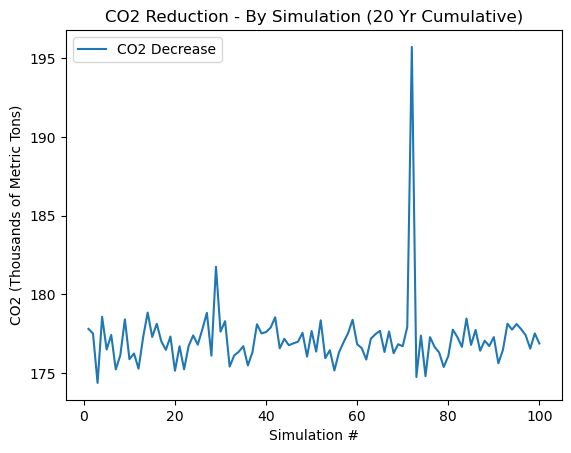

In [20]:
unit = 1000
x = df_Sim['Sim']
a = df_Sim['CO2 Decrease']/unit


plt.plot(x, a, label = 'CO2 Decrease')
plt.xlabel('Simulation #')
plt.ylabel('CO2 (Thousands of Metric Tons)')
plt.title('CO2 Reduction - By Simulation (20 Yr Cumulative)')
plt.legend()

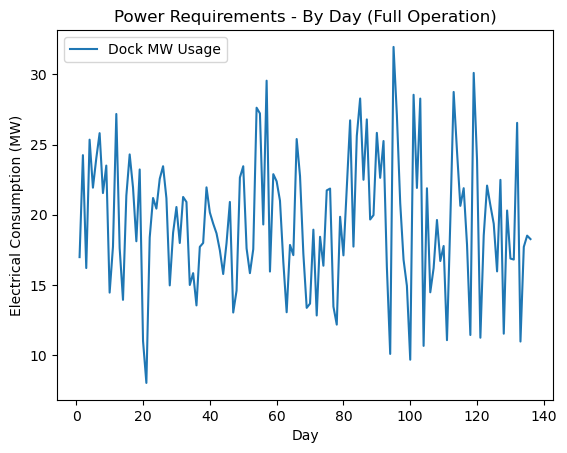

In [21]:
x = df_Day['Day']
a = df_Day['Elec Consumption']
#b = df_Day['NoX Cumul Unadj Total']/1000000


plt.plot(x, a, label = 'Dock MW Usage')
#plt.plot(x, b, label = 'Est Cumulative NoX')
plt.xlabel('Day')
plt.ylabel('Electrical Consumption (MW)')
plt.title('Power Requirements - By Day (Full Operation)')
plt.legend()

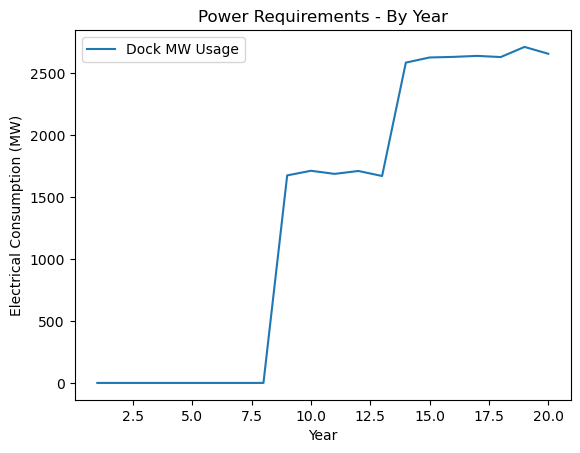

In [22]:
x = df_Year['Year']
a = df_Year['Elec Consumption']
#b = df_Day['NoX Cumul Unadj Total']/1000000


plt.plot(x, a, label = 'Dock MW Usage')
#plt.plot(x, b, label = 'Est Cumulative NoX')
plt.xlabel('Year')
plt.ylabel('Electrical Consumption (MW)')
plt.title('Power Requirements - By Year')
plt.legend()

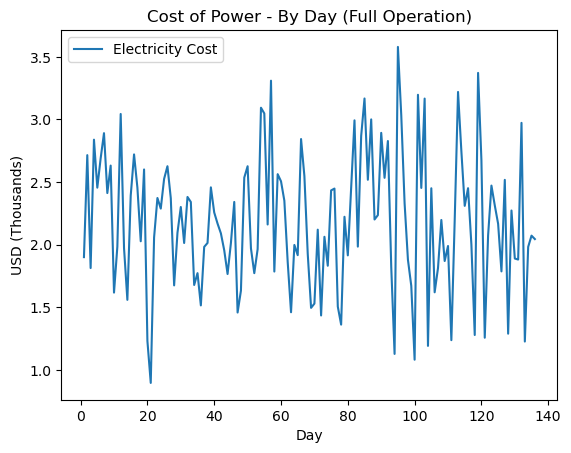

In [23]:
unit = 1000
x = df_Day['Day']
a = df_Day['Elec Consumption Cost']/unit

plt.plot(x, a, label = 'Electricity Cost')
plt.xlabel('Day')
plt.ylabel('USD (Thousands)')
plt.title('Cost of Power - By Day (Full Operation)')
plt.legend()

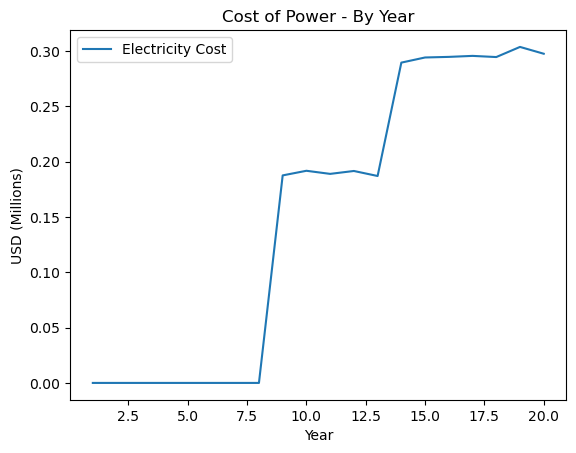

In [24]:
unit = 1000000
x = df_Year['Year']
a = df_Year['Elec Consumption Cost']/unit

plt.plot(x, a, label = 'Electricity Cost')
plt.xlabel('Year')
plt.ylabel('USD (Millions)')
plt.title('Cost of Power - By Year')
plt.legend()

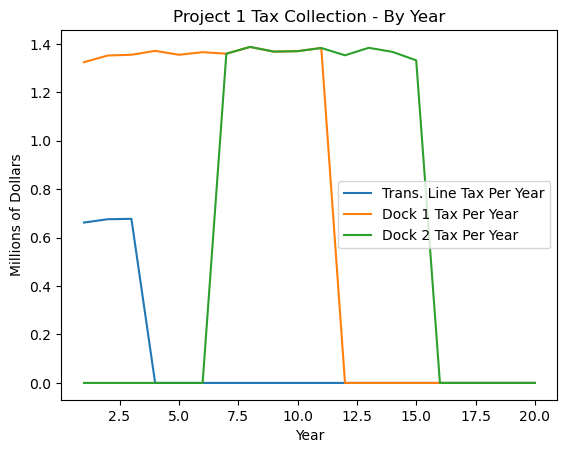

In [25]:
unit = 1000000
x = df_Year['Year']
a = df_Year['Trans. Line Tax']/unit
b = df_Year['Dock 1 Tax']/unit
c = df_Year['Dock 2 Tax']/unit



plt.plot(x, a, label = 'Trans. Line Tax Per Year')
plt.plot(x, b, label = 'Dock 1 Tax Per Year')
plt.plot(x, c, label = 'Dock 2 Tax Per Year')
plt.xlabel('Year')
plt.ylabel('Millions of Dollars')
plt.title('Project 1 Tax Collection - By Year')
plt.legend()

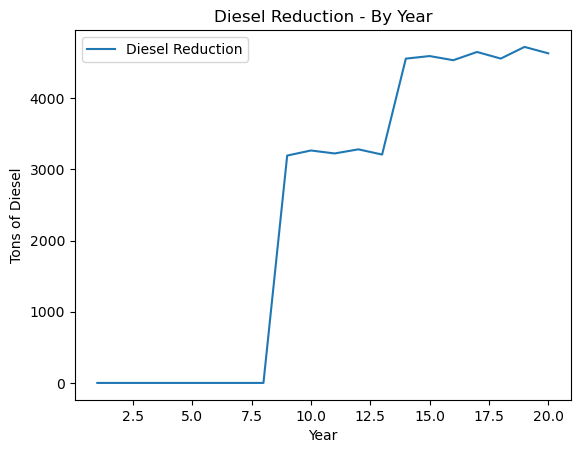

In [26]:
unit = Gal_Per_Ton          # 286 Gallons per ton
x = df_Year['Year']
a = df_Year['Diesel Reduction']/unit



plt.plot(x, a, label = 'Diesel Reduction')
plt.xlabel('Year')
plt.ylabel('Tons of Diesel')
plt.title('Diesel Reduction - By Year')
plt.legend()

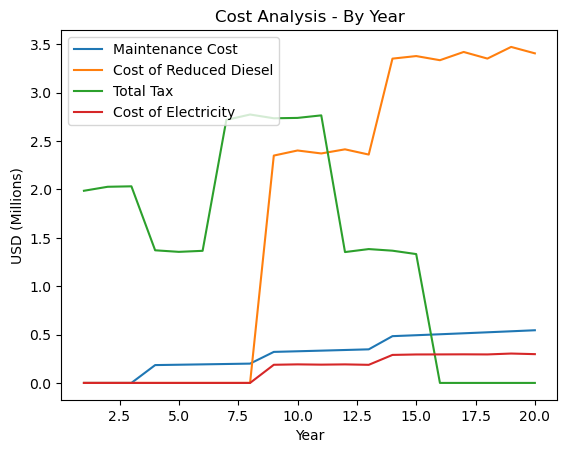

In [27]:
unit = 1000000           # Hundreds of Thousands 
x = df_Year['Year']
a = df_Year['Maint Total']/unit
b = df_Year['Diesel Reduction Cost']/unit
c = df_Year['Tax Total']/unit
d= df_Year['Elec Consumption Cost']/unit

plt.plot(x, a, label = 'Maintenance Cost')
plt.plot(x, b, label = 'Cost of Reduced Diesel')
plt.plot(x, c, label = 'Total Tax')
plt.plot(x, d, label = 'Cost of Electricity')
plt.xlabel('Year')
plt.ylabel('USD (Millions)')
plt.title('Cost Analysis - By Year')
plt.legend()

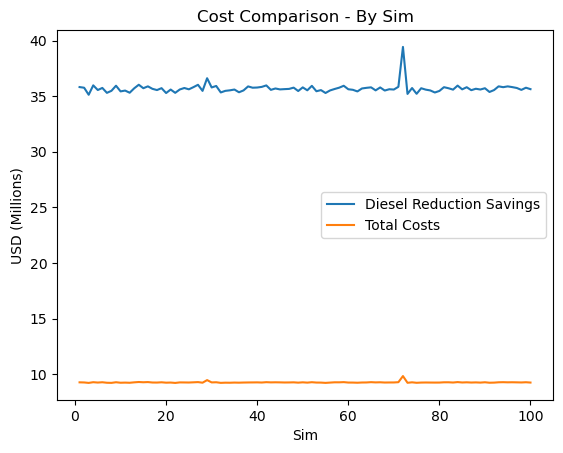

In [28]:
unit = 1000000          # millions of dollars
x = df_Sim['Sim']
a = df_Sim['Diesel Reduction Cost']/unit
c = df_Sim['Tax Total']/unit
d = df_Sim['Total Costs']/unit


plt.plot(x, a, label = 'Diesel Reduction Savings')
plt.plot(x, d, label = 'Total Costs')
plt.xlabel('Sim')
plt.ylabel('USD (Millions)')
plt.title('Cost Comparison - By Sim')
plt.legend()